## Imports

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
from torch import nn     # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss function
import torch.optim as optim     # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F     # All functions that don't have any parameters
from torch.utils.data import TensorDataset, DataLoader     # Gives easier dataset management and creates mini batchs
import torchvision.transforms as transforms     # Transformations we can perform on our dataset

import warnings
warnings.simplefilter("ignore")

print("PyTorch version " + torch.__version__)

PyTorch version 1.13.1+cu117


## Import utility functions

In [144]:
from helper_train import train_autoencoder_v1
from helper_data import get_dataloaders_mnist
from helper_train import train_vae_v1, train_vae_v2
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_training_loss
from helper_plotting import plot_accuracy
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae

In [171]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 42
LEARNING_RATE = 0.0005
BATCH_SIZE = 278
NUM_EPOCHS = 10000

Device: cuda:0


In [172]:
set_deterministic
set_all_seeds(RANDOM_SEED)

## 1. ETL (Extract, Transform, Load)

In [173]:
df = pd.read_csv('datasets/selected_500user.csv')
df

,MeterID,DATE-Time,KWH
0,6200093839,2021-01-01 00:00:00,0.602
1,6200093839,2021-01-01 00:15:00,0.589
2,6200093839,2021-01-01 00:30:00,0.410
3,6200093839,2021-01-01 00:45:00,0.495
4,6200093839,2021-01-01 01:00:00,0.450
...,...,...,...
16967640,6200091271,2021-12-31 22:45:00,1.323
16967641,6200091271,2021-12-31 23:00:00,1.327
16967642,6200091271,2021-12-31 23:15:00,1.321
16967643,6200091271,2021-12-31 23:30:00,1.311


## 2. EDA (Exploratory Data Analysis)

In [174]:
def clean_data(df):
    # Get unique MeterID values
    unique_meter_ids = df['MeterID'].unique()

    # Create a new list of user IDs as strings
    user_ids = [str(i) for i in range(len(unique_meter_ids))]

    # Create a dictionary that maps each unique MeterID value to a unique user ID
    user_id_dict = {meter_id: user_id for meter_id, user_id in zip(unique_meter_ids, user_ids)}

    # Create a new column "user" that maps each MeterID value to a user ID
    df["user"] = df["MeterID"].apply(lambda x: user_id_dict[x])

    # Select user_1 to explore
    user_1 = df[df['user']=='0']

    # Drop not useful columns
    user_1['DATE-Time'] = pd.to_datetime(user_1['DATE-Time'], infer_datetime_format=True)
    user_1.drop(columns=["MeterID", "user"], inplace=True)

    # Resample `15min` in order to have completed `"DATE-Time"`
    # I have `'DATE-Time'` 32760 rows (32760/96=341.25 Days)
    # It should be (365day * 96point = 35040 rows)
    # I have to reset index in order to hava 35040 rows
    # Fill the missing value
    user_1 = user_1.set_index('DATE-Time').resample("15T").mean()

    # Drop the days that have NaN values
    # Check which rows have at least one missing value
    missing_days = user_1.isnull().any(axis=1)

    # Get the dates (i.e., indices) of the rows that have missing values
    missing_days_index = missing_days[missing_days].index

    # Get the unique dates that have missing values
    missing_dates = pd.Series(missing_days_index.date).unique().tolist()

    # Drop the entire dates that contain Nan values
    user_1_clean = user_1[~user_1.index.to_series().dt.date.isin(missing_dates)]
    
    return user_1_clean

In [175]:
user_1_clean = clean_data(df)
user_1_clean

,KWH
DATE-Time,
2021-01-01 00:00:00,0.602
2021-01-01 00:15:00,0.589
2021-01-01 00:30:00,0.410
2021-01-01 00:45:00,0.495
2021-01-01 01:00:00,0.450
...,...
2021-12-31 22:45:00,0.405
2021-12-31 23:00:00,0.349
2021-12-31 23:15:00,0.305


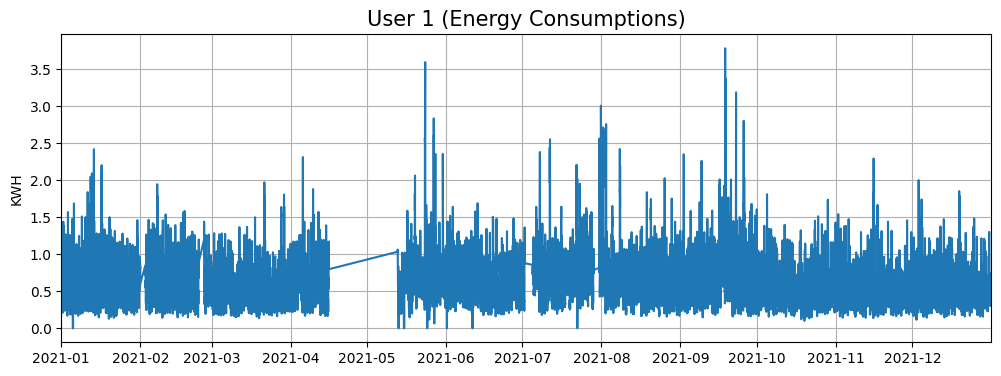

In [176]:
plt.figure(figsize=(12,4))
plt.title('User 1 (Energy Consumptions)', size=15)
plt.ylabel('KWH')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(user_1_clean['KWH'])
plt.show()

## 3. Prepare the data

In [177]:
def create_windowed_dataset(data, window_size):
    # Calculate the number of windows that fit in the data
    num_windows = len(data) // window_size
    
    # Truncate data to fit into windowed data exactly
    data = data[:num_windows*window_size]
    
    # Reshape the data into a 3D tensor of (num_windows, window_size, num_features)
    windowed_data = np.reshape(data, (num_windows, window_size, 1))
    
    return windowed_data

# Example usage
window_size = 96
data = user_1_clean.to_numpy()
windowed_data = create_windowed_dataset(data, window_size)
print(f" Window shape : {windowed_data.shape}")
print(f" Type of Window : {type(windowed_data)}")

 Window shape : (329, 96, 1)
 Type of Window : <class 'numpy.ndarray'>


The shape of the dataset (for selected `User_1`) is `(329, 96, 1)` which means: 
* we have `329` samples `(i.e., 329 non-overlapping windows)`,
* each window has `96` time steps `(i.e., 96 data points)`,
* and `1` feature `(i.e., KWH)`.

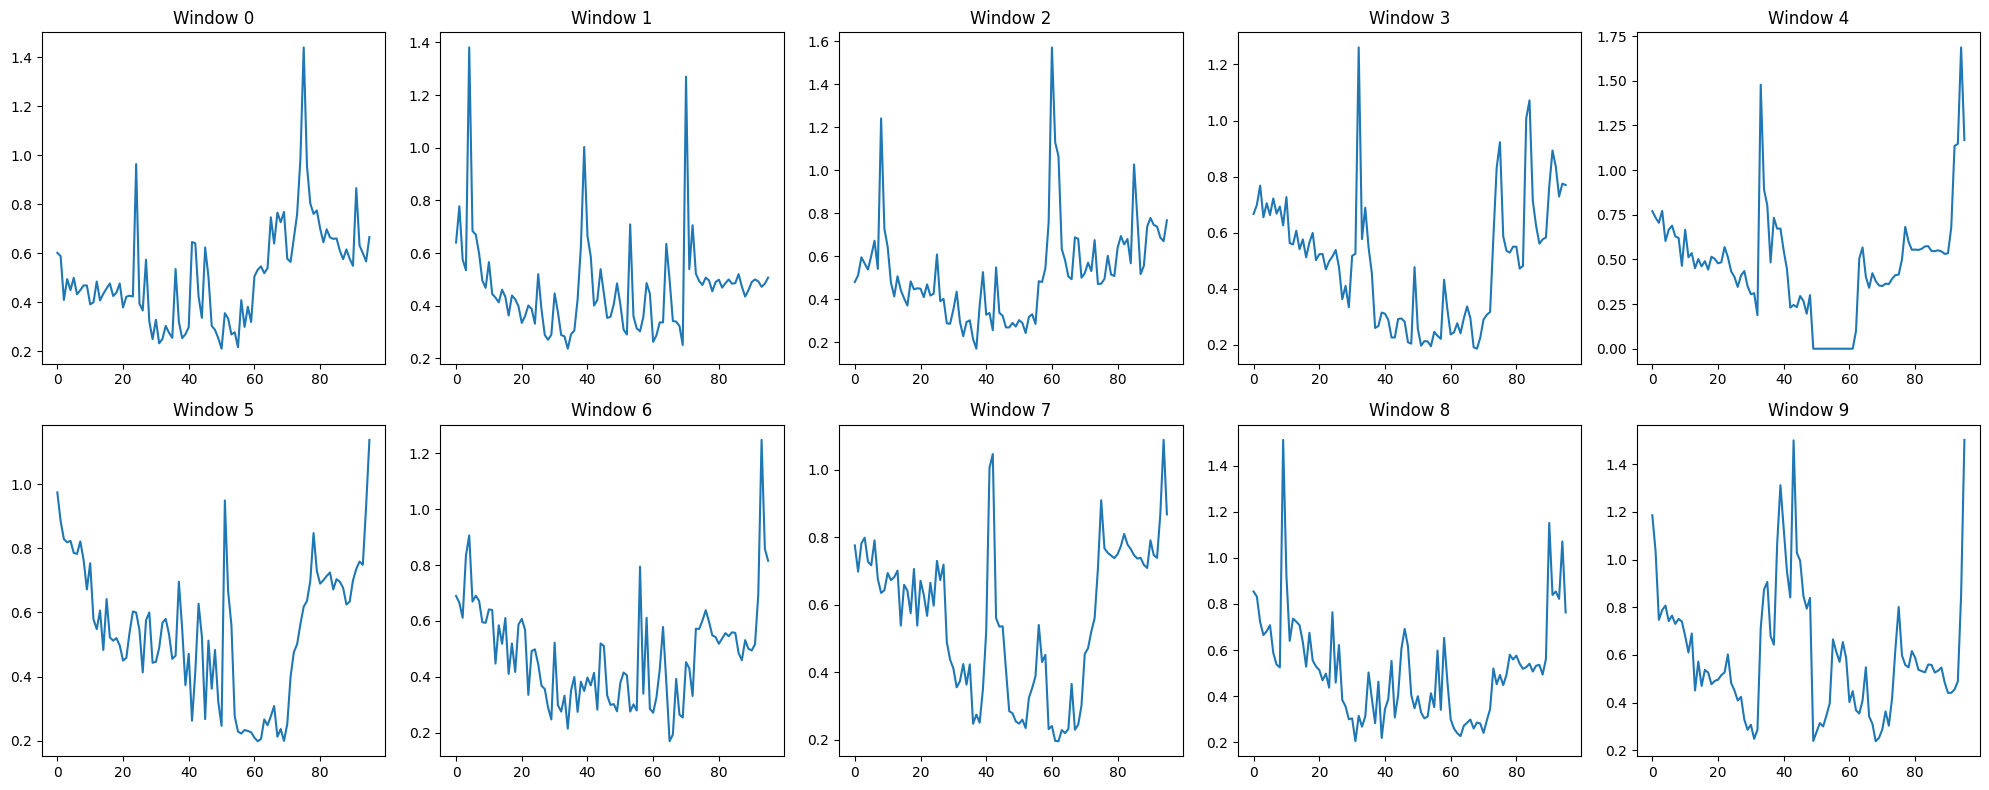

In [178]:
# Plot the first 10 windows
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
for i, ax in enumerate(axs.flatten()):
    ax.plot(windowed_data[i])
    ax.set_title(f"Window {i}")
plt.tight_layout()
plt.show()

### Divide the data into train, validation, and test sets

`train_data_tensor[:-1]` and `train_data_tensor[1:]` are indexing operations on the `train_data_tensor` PyTorch tensor.

`train_data_tensor[:-1]` means all elements of `train_data_tensor` except for the last one. 
* This is because in the context of the autoencoder model, we will be predicting the next time step based on the current time step, so the last element of train_data_tensor cannot be used as a predictor.

`train_data_tensor[1:]` means all elements of `train_data_tensor` except for the first one. 
* This is because in the context of the autoencoder model, we will be training the model to predict the next time step given the current time step, so the first element of train_data_tensor cannot be used as a prediction target.

In summary, `train_dataset` contains tuples of `input` and `target` data, where the input data is `train_data_tensor[:-1]` and the target data is `train_data_tensor[1:]`.

In [179]:
# Divide the data into training and test sets
train_data, val_data = train_test_split(windowed_data, test_size=0.15, shuffle=False)
val_data, test_data = train_test_split(val_data, test_size=0.33, shuffle=False)

# Reshape the data to have 2 dimensions
train_data_2dim = train_data.reshape(train_data.shape[0], -1)
val_data_2dim = val_data.reshape(val_data.shape[0], -1)
test_data_2dim = test_data.reshape(test_data.shape[0], -1)

# Normalize the training set between 0 and 1 (Using traning data)
scaler = MinMaxScaler()
train_data_norm = scaler.fit_transform(train_data_2dim)

# Convert the numpy arrays to PyTorch tensors
train_data_tensor = torch.from_numpy(train_data_norm).float().view(-1, 1, window_size)   # `(batch_size, in_channels, sequence_length)`
val_data_tensor = torch.from_numpy(val_data_2dim).float().view(-1, 1, window_size)   # `(batch_size, in_channels, sequence_length)`
test_data_tensor = torch.from_numpy(test_data_2dim).float().view(-1, 1, window_size)       # `(batch_size, in_channels, sequence_length)`

# Prepare the data for the model using TensorDataset and DataLoader
train_dataset = TensorDataset(train_data_tensor[:-1], train_data_tensor[1:])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(val_data_tensor[:-1], val_data_tensor[1:])
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(test_data_tensor[:-1], test_data_tensor[1:])
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [180]:
# Check the shape
print("Number of batches in train dataloader:", len(train_dataloader))
print("Number of batches in validation dataloader:", len(val_dataloader))
print("Number of batches in test dataloader:", len(test_dataloader))

Number of batches in train dataloader: 1
Number of batches in validation dataloader: 1
Number of batches in test dataloader: 1


In [181]:
# Check Min and Max of Training dataloader
dataiter = iter(train_dataloader)
x, y = next(dataiter)
print(torch.min(x), torch.max(x))

tensor(0.) tensor(1.)


In [182]:
# Iterate through the dataloaders and check the shape of the batches
print("Train")
for i, batch in enumerate(train_dataloader):
    x, y = batch
    print("Shape of batch ", i+1, "in train dataloader:", x.shape, y.shape)

print("\nValidation")
for i, batch in enumerate(val_dataloader):
    x, y = batch
    print("Shape of batch ", i+1, "in val dataloader:", x.shape, y.shape)    
    
print("\nTest")
for i, batch in enumerate(test_dataloader):
    x, y = batch
    print("Shape of batch ", i+1, "in test dataloader:", x.shape, y.shape)

Train
Shape of batch  1 in train dataloader: torch.Size([278, 1, 96]) torch.Size([278, 1, 96])

Validation
Shape of batch  1 in val dataloader: torch.Size([32, 1, 96]) torch.Size([32, 1, 96])

Test
Shape of batch  1 in test dataloader: torch.Size([16, 1, 96]) torch.Size([16, 1, 96])


In the case of autoencoder, `x` usually represents the input data and `y` is the same as `x` as the model tries to reconstruct the input data as the output. 

The goal of an autoencoder is to learn a compressed representation of the input data in the encoding stage, and then to reconstruct the original data in the decoding stage.

In [183]:
for i, (x, y) in enumerate(train_dataloader):
    print(f"Batch {i}:")
    print(f"x = {x}")
    print(f"y = {y}")
    break

Batch 0:
x = tensor([[[0.7638, 0.4791, 0.2480,  ..., 0.3856, 0.6878, 0.6705]],

        [[0.3256, 0.3292, 0.2340,  ..., 0.3064, 0.3034, 0.6898]],

        [[0.3570, 0.2547, 0.2784,  ..., 0.4019, 0.3429, 0.4095]],

        ...,

        [[0.0895, 0.0827, 0.0723,  ..., 0.0784, 0.0551, 0.0668]],

        [[0.3736, 0.3325, 0.2201,  ..., 0.4135, 0.2878, 0.3691]],

        [[0.3616, 0.2711, 0.2061,  ..., 0.3522, 0.3034, 0.3383]]])
y = tensor([[[0.5554, 0.4259, 0.3027,  ..., 0.1870, 0.1646, 0.2083]],

        [[0.8192, 0.4054, 0.2669,  ..., 0.1971, 0.1762, 0.1889]],

        [[0.3801, 0.3514, 0.2796,  ..., 0.3398, 0.2939, 0.3076]],

        ...,

        [[0.0572, 0.0131, 0.0632,  ..., 0.1575, 0.1912, 0.1696]],

        [[0.3533, 0.2473, 0.2195,  ..., 0.3289, 0.2952, 0.3779]],

        [[0.3376, 0.3260, 0.1915,  ..., 0.3204, 0.2959, 0.3067]]])


### 4. Define the model

This model takes in a tensor of shape `(batch_size, sequence_length, num_features)` as input and outputs a tensor of the same shape. 

We use `Conv1d` layers for the encoder and `ConvTranspose1d` layers for the decoder.

Note that the number of input channels for the first Conv1d layer is 1, because we are using a univariate time series as input. 

If you had a multivariate time series, you would set the number of input channels to the number of features in your data.

You can adjust the number of channels and the kernel sizes of the convolutional layers to increase or decrease the complexity of the model.

In [184]:
# OLD VERSION !!!----------------------------------------------------------------

# class ConvAutoencoder(nn.Module):
#     def __init__(self):
#         super(ConvAutoencoder, self).__init__()
#         # Encoder layers
#         self.enc_conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1)
#         self.enc_conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
#         self.enc_conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
#         self.enc_conv4 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=12)
        
#         # Decoder layers
#         self.dec_conv1 = nn.ConvTranspose1d(in_channels=128, out_channels=64, kernel_size=12)
#         self.dec_conv2 = nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1,output_padding=1)
#         self.dec_conv3 = nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1,output_padding=1)
#         self.dec_conv4 = nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1,output_padding=1)
        
#         self.relu = nn.ReLU()
#         self.tanh = nn.Tanh()
        
#     def forward(self, x):
#         # Encoder
#         x = self.enc_conv1(x)
#         x = self.relu(x)
#         # print("Encoder Conv1 Output Shape: ", x.shape)
#         x = self.enc_conv2(x)
#         x = self.relu(x)
#         # print("Encoder Conv2 Output Shape: ", x.shape)
#         x = self.enc_conv3(x)
#         x = self.relu(x)
#         # print("Encoder Conv3 Output Shape: ", x.shape)
#         x = self.enc_conv4(x)
#         x = self.relu(x)
#         # print("Encoder Conv4 Output Shape: ", x.shape)

#         # Decoder
#         x = self.dec_conv1(x)
#         x = self.relu(x)
#         # print("Decoder ConvTranspose1 Output Shape: ", x.shape)
#         x = self.dec_conv2(x)
#         x = self.relu(x)
#         # print("Decoder ConvTranspose2 Output Shape: ", x.shape)
#         x = self.dec_conv3(x)
#         x = self.relu(x)
#         # print("Decoder ConvTranspose3 Output Shape: ", x.shape)
#         x = self.dec_conv4(x)
#         # x = self.relu(x)
#         # print("Decoder ConvTranspose4 Output Shape: ", x.shape)
#         x = self.tanh(x)
        
#         return x

In [185]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]
    

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(0.1),
                # nn.Dropout(0.2),
                nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
                nn.LeakyReLU(0.1),
                # nn.Dropout(0.2),
                nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
                nn.LeakyReLU(0.1),
                # nn.Dropout(0.2),
                nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(1536, 2)
        self.z_log_var = torch.nn.Linear(1536, 2)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 1536),
                Reshape(-1, 64, 24),
                nn.ConvTranspose1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(0.1),
                # nn.Dropout(0.1),
                nn.ConvTranspose1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),                
                nn.LeakyReLU(0.1),
                # nn.Dropout(0.1),
                nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),                
                nn.LeakyReLU(0.1),
                # nn.Dropout(0.1),
                nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1), 
                nn.Sigmoid()
                )

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

The input shape for `Conv1d` should be `(batch_size, num_features, sequence_length)`. 

In our case, the batch size is determined by the batch_size argument in the `DataLoader`, the number of features is `1`, and the sequence length is the window size which is `96`. 

So, the shape of each input should be `(batch_size, 1, 96)`.

---

If we use `Conv2d` instead of `Conv1d`, the input shape should be `(batch_size, 1, window_size, 1)` instead of `(batch_size, window_size, 1)`.

This is because `Conv2d` expects a 4D tensor where the second dimension represents the number of channels. 

In our case, we only have one channel, so we set this dimension to `1`. The fourth dimension is set to 1 because we only have one feature.

---

If you want to use `Conv1d`, then the shape of the input tensor should be `(batch_size, in_channels, sequence_length)`, where `in_channels` is 1 in your case since you have a single feature. 

So for your specific case, the shape of the input tensor should be `(batch_size, 1, window_size)`, where `window_size` is 96.

However, if you decide to use `Conv2d`, then the shape of the input tensor should be `(batch_size, in_channels, height, width)`. 

Since you only have one feature, the `in_channels` would still be 1. 

You can choose the `height` and `width` of the input tensor based on the window size and how you want to shape the data for the convolutional layers. 

For example, you could set `height=1` and `width=window_size`, or you could set `height=window_size` and `width=1`

### Define loss and optimization functions

In [186]:
# import torch.optim as optim

# model = ConvAutoencoder().to(device)
# criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# model

In [189]:
set_all_seeds(RANDOM_SEED)

model = VAE()
model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)  

model

VAE(
  (encoder): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): LeakyReLU(negative_slope=0.1)
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (3): LeakyReLU(negative_slope=0.1)
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(2,), padding=(1,))
    (5): LeakyReLU(negative_slope=0.1)
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): Flatten(start_dim=1, end_dim=-1)
  )
  (z_mean): Linear(in_features=1536, out_features=2, bias=True)
  (z_log_var): Linear(in_features=1536, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=1536, bias=True)
    (1): Reshape()
    (2): ConvTranspose1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): LeakyReLU(negative_slope=0.1)
    (4): ConvTranspose1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): LeakyReLU(negative_slope=0.1)
    (6): ConvTranspose1d(64, 32, kernel_size=(3,), stride=(2,)

In [190]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

    96
    32
  6144
    64
 12288
    64
 12288
    64
  3072
     2
  3072
     2
  3072
  1536
 12288
    64
 12288
    64
  6144
    32
    96
     1
______
 72773


In [191]:
from pynvml import *
gb = pow(1024,3)
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total/gb:.2f} GB')
print(f'free     : {info.free/gb:.2f} GB')
print(f'used     : {info.used/gb:.2f} GB')

h = nvmlDeviceGetHandleByIndex(1)
info = nvmlDeviceGetMemoryInfo(h)
print(f'\ntotal    : {info.total/gb:.2f} GB')
print(f'free     : {info.free/gb:.2f} GB')
print(f'used     : {info.used/gb:.2f} GB')

total    : 47.99 GB
free     : 24.83 GB
used     : 23.16 GB

total    : 11.00 GB
free     : 10.13 GB
used     : 0.87 GB


In [192]:
# for seq, y_train in train_data:
#     print(seq)
#     print(y_train)
#     break

### Train the model

`Conv1d` require the input shape `(batch_size, in_channels, sequence_length)`

We have to change from `(32, 96, 1)` to `(32, 1 ,96)` by using `permute`

`(batch_size, sequence_length, in_channels)`->`(batch_size, in_channels, sequence_length)`

In [193]:
# # Iterate through the dataloaders and check the shape of the batches
# print("Train")
# for i, batch in enumerate(train_dataloader):
#     x, y = batch
    
#     # Permute the dimensions of the tensor
#     x = x.permute(0, 2, 1)
    
#     print("Shape of batch ", i+1, "in train dataloader:", x.shape, y.shape)

# print("\nTest")
# for i, batch in enumerate(test_dataloader):
#     x, y = batch
    
#     # Permute the dimensions of the tensor
#     x = x.permute(0, 2, 1)
    
#     print("Shape of batch ", i+1, "in test dataloader:", x.shape, y.shape)

In [194]:
log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer=optimizer, device=DEVICE, 
                        train_loader=train_dataloader,
                        skip_epoch_stats=True,
                        logging_interval=50)

Epoch: 001/10000 | Batch 0000/0001 | Loss: 6.0241
Time elapsed: 0.00 min
Epoch: 002/10000 | Batch 0000/0001 | Loss: 5.9040
Time elapsed: 0.00 min
Epoch: 003/10000 | Batch 0000/0001 | Loss: 5.8079
Time elapsed: 0.00 min
Epoch: 004/10000 | Batch 0000/0001 | Loss: 5.7000
Time elapsed: 0.00 min
Epoch: 005/10000 | Batch 0000/0001 | Loss: 5.5981
Time elapsed: 0.00 min
Epoch: 006/10000 | Batch 0000/0001 | Loss: 5.4921
Time elapsed: 0.00 min
Epoch: 007/10000 | Batch 0000/0001 | Loss: 5.3883
Time elapsed: 0.00 min
Epoch: 008/10000 | Batch 0000/0001 | Loss: 5.3248
Time elapsed: 0.00 min
Epoch: 009/10000 | Batch 0000/0001 | Loss: 5.2297
Time elapsed: 0.00 min
Epoch: 010/10000 | Batch 0000/0001 | Loss: 5.1426
Time elapsed: 0.00 min
Epoch: 011/10000 | Batch 0000/0001 | Loss: 5.0563
Time elapsed: 0.00 min
Epoch: 012/10000 | Batch 0000/0001 | Loss: 4.9968
Time elapsed: 0.00 min
Epoch: 013/10000 | Batch 0000/0001 | Loss: 4.9378
Time elapsed: 0.00 min
Epoch: 014/10000 | Batch 0000/0001 | Loss: 4.8495
T

### Evaluation

https://machinelearningmastery.com/using-dropout-regularization-in-pytorch-models/

In [195]:
# OLD VERSION !!!----------------------------------------------------------------
# epochs = 2000
# outputs = []
# import time
# start_time = time.time()

# for epoch in range(epochs):
    
#     # extract the sequence & label from the training data
#     for seq, y_train in train_dataloader:
        
#         #seq & y_train to device
#         seq = seq.to(device)
#         # print(f"seq ={seq.shape}")
#         y_train = y_train.to(device)
#         # print(f"y_train ={y_train.shape}")
#         optimizer.zero_grad()     # reset the parameters
#         # Forward pass
#         y_pred = model(seq)                                  # 1. model
#         # print(f"y_pred ={y_pred.shape}")
#         # update parameters
#         loss = criterion(y_pred, y_train)    # 2. loss ,This should give you a tensor of shape `[batch_size, 1, seq_length]`
        
#         # Backward and optimize
#         # optimizer.zero_grad()     # reset the parameters
#         loss.backward()
#         optimizer.step()
#         # break
#     # print loss after each epoch
#     if epoch % 100 == 0:
#         print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
#     outputs.append((epoch, y_train, y_pred))    
# print(f'\nDuration: {time.time() - start_time:.0f} seconds')

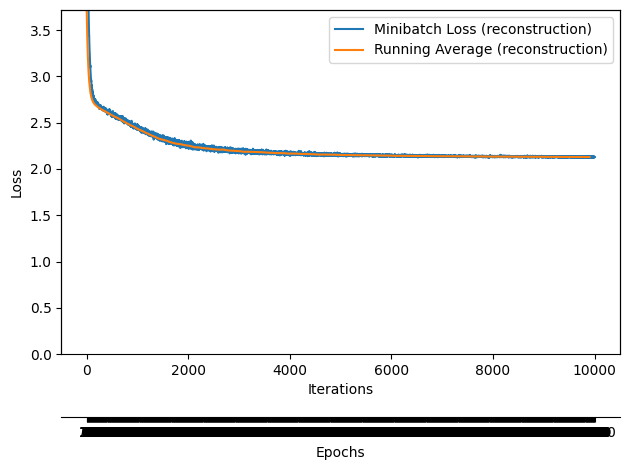

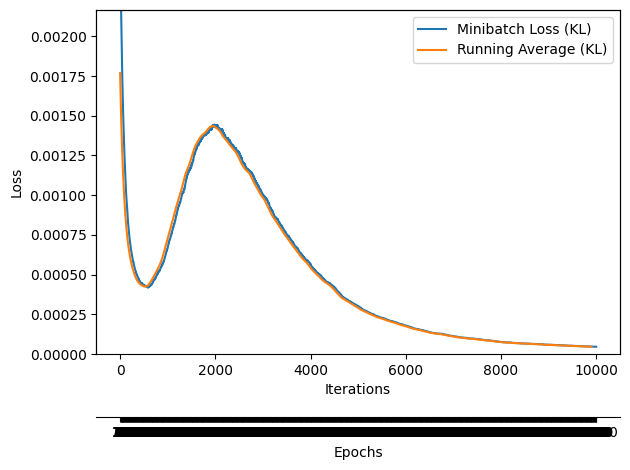

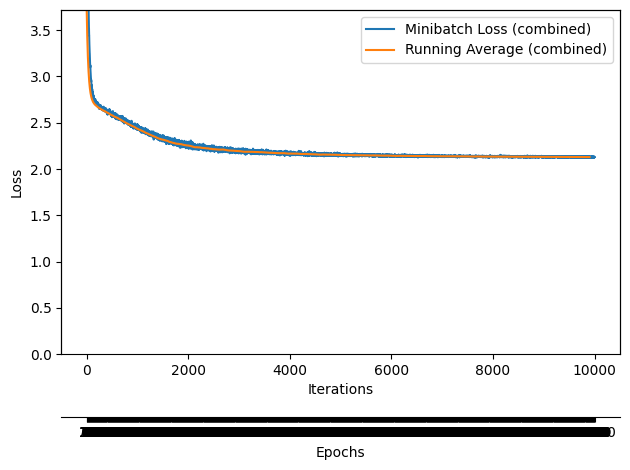

In [196]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

In [60]:
log_dict.keys()

dict_keys(['train_combined_loss_per_batch', 'train_combined_loss_per_epoch', 'train_reconstruction_loss_per_batch', 'train_kl_loss_per_batch', 'train_acc_per_epoch', 'valid_acc_per_epoch', 'valid_loss_per_epoch'])

In [61]:
log_dict['train_combined_loss_per_epoch']

[]

In [60]:
log_dict['train_acc_per_epoch']

[]

### Test

In [74]:
# USE THIS FOR CHECK THE SHAPE !!!!!
class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :96, 1]

class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder layers
        self.enc_conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.enc_conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.enc_conv3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.enc_conv4 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # Decoder layers
        self.dec_conv1 = nn.ConvTranspose1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.dec_conv2 = nn.ConvTranspose1d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.dec_conv3 = nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_conv4 = nn.ConvTranspose1d(in_channels=32, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1)  #,output_padding=1
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        # Encoder
        x = self.enc_conv1(x)
        x = self.relu(x)
        print("Encoder Conv1 Output Shape: ", x.shape)
        x = self.enc_conv2(x)
        x = self.relu(x)
        print("Encoder Conv2 Output Shape: ", x.shape)
        x = self.enc_conv3(x)
        x = self.relu(x)
        print("Encoder Conv3 Output Shape: ", x.shape)
        x = self.enc_conv4(x)
        x = self.relu(x)
        print("Encoder Conv4 Output Shape: ", x.shape)
        x = self.flatten(x)
        print("Encoder Flatten Output Shape: ", x.shape)

        # Decoder
        x = x.reshape(-1, 64, 24)
        x = self.dec_conv1(x)
        x = self.relu(x)
        print("Decoder ConvTranspose1 Output Shape: ", x.shape)
        x = self.dec_conv2(x)
        x = self.relu(x)
        print("Decoder ConvTranspose2 Output Shape: ", x.shape)
        x = self.dec_conv3(x)
        x = self.relu(x)
        print("Decoder ConvTranspose3 Output Shape: ", x.shape)
        x = self.dec_conv4(x)
        print("Decoder ConvTranspose4 Output Shape: ", x.shape)
        x = self.tanh(x)
        
        return x
    
model = ConvAutoencoder()

# Create a dummy input
x = torch.randn(1, 1, 96)

# Call the model with the input
y = model(x)

# Check the output shape
print("Final Output Shape: ", y.shape)

Encoder Conv1 Output Shape:  torch.Size([1, 32, 96])
Encoder Conv2 Output Shape:  torch.Size([1, 64, 48])
Encoder Conv3 Output Shape:  torch.Size([1, 64, 24])
Encoder Conv4 Output Shape:  torch.Size([1, 64, 24])
Encoder Flatten Output Shape:  torch.Size([1, 1536])
Decoder ConvTranspose1 Output Shape:  torch.Size([1, 64, 24])
Decoder ConvTranspose2 Output Shape:  torch.Size([1, 64, 24])
Decoder ConvTranspose3 Output Shape:  torch.Size([1, 32, 48])
Decoder ConvTranspose4 Output Shape:  torch.Size([1, 1, 96])
Final Output Shape:  torch.Size([1, 1, 96])


In [117]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :96]


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                nn.Conv1d(1, 16, kernel_size=3, stride=2, padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv1d(16, 32, kernel_size=3, stride=2, padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv1d(64, 128, kernel_size=12),
                nn.LeakyReLU(0.01),
                nn.Flatten(),
                nn.Linear(128*6, 2)
        )
        self.decoder = nn.Sequential(
                torch.nn.Linear(2, 128*6),
                Reshape(-1, 128, 6),
                nn.ConvTranspose1d(128, 64, kernel_size=12),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose1d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose1d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
                Trim(),
                nn.Sigmoid()
                )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = AutoEncoder()

# Create a dummy input
x = torch.randn(1, 1, 96)

# Call the model with the input
y = model(x)

# Check the output shape
print("Final Output Shape: ", y.shape)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x128 and 768x2)

## 5. Evaluate the model using the test set

In [65]:
len(test_set)

7008

In [71]:
future = 96
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:]).to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size).to(device),
                        torch.zeros(1,1,model.hidden_size).to(device))
        preds.append(model(seq).item())
        
preds[window_size:][:5]

[-0.6371443271636963,
 -0.6486324667930603,
 -0.6592532396316528,
 -0.6689152717590332,
 -0.6776772737503052]

### Inverse transform the predicted values

Rescale the predicted values up to the original test set range.

In [70]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
true_predictions[:5]

array([[0.68652293],
       [0.66478737],
       [0.64469287],
       [0.62641231],
       [0.6098346 ]])

### Plot the result

Plot the true_predictions values together with the original data. Remember to create a range of datetime values for the predicted data.

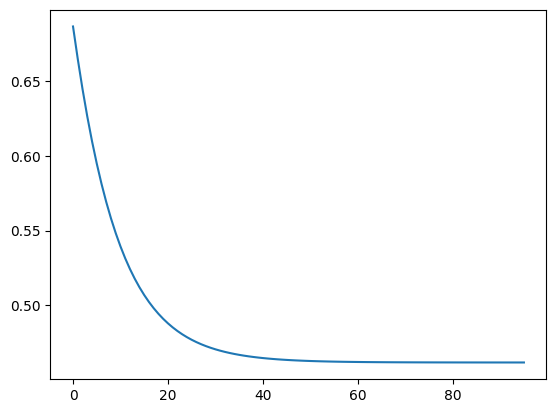

In [73]:
# plt.figure(figsize=(12,4))
# plt.title('Industrial Production Index for Electricity and Gas Utilities')
# plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
# plt.grid(True)
# plt.autoscale(axis='x',tight=True)
# plt.plot(data['KWH'])
plt.plot(true_predictions)
plt.show()

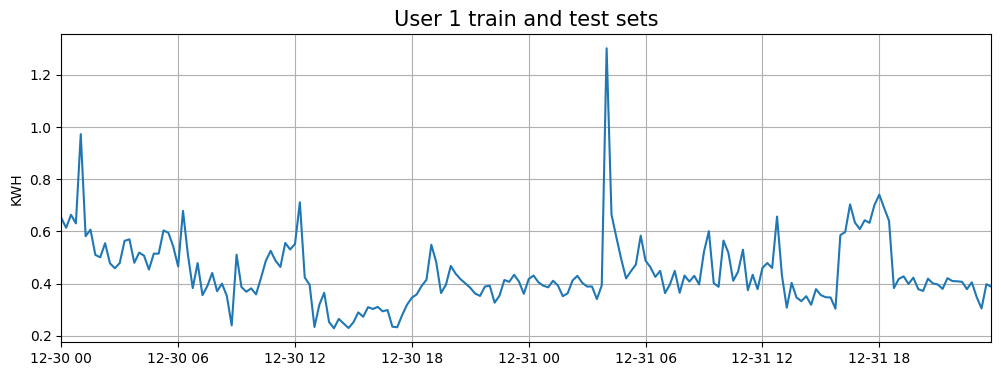

In [85]:
plt.figure(figsize=(12,4))
plt.title('User 1 train and test sets', size=15)
plt.ylabel('KWH')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(data['KWH']['2021-12-30':'2021-12-31'])
plt.show()

# Task

### VAE autocoder
* https://www.google.com/search?q=variational+autoencoder+based+anomaly+detection+using+reconstruction+probability+github&rlz=1C5CHFA_enTH999TH999&oq=Variational+Autoencoder+based+Anomaly+Detection+using+Reconstruction+Probability+&aqs=chrome.1.69i57j0i512j69i60.3070j0j7&sourceid=chrome&ie=UTF-8
* https://github.com/Michedev/VAE_anomaly_detection
* https://github.com/smile-yan/vae-anomaly-detection
* https://github.com/tarekmuallim/Anomaly-Detection-using-Variational-Autoencoders/blob/master/anomaly_detection_using_vae.py


### CNN
* https://github.com/khanmhmdi/Cifar-Image-Reconstruction-using-Autoencoder-Models/blob/main/Image_reconstruction.ipynb
* https://github.com/ebrahimpichka/conv-autoencoder (test on this now!!)